# Gaussian Filter

In [1]:
# import required libraries
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, math
import time

## 2.1 Mirroring
The boundary of an image is a problem for a gaussian filter. We will solve this problem by mirroring the image at the boundary.
We will assume odd, square convolution matrices $K$ of size $h\times h$ and implement the function *imgmirror* that mirrors a strip of width $w$ at the boundaries of the matrix $M \in \mathbb{R}^{n\times m}$. We should get an output matrix $O \in \mathbb{R}^{(n+2\cdot w)\times(m+2\cdot w)}$.

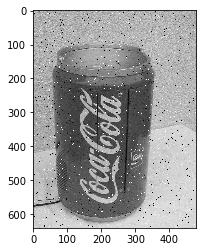

In [2]:
img = mpimg.imread('data/noisycoke.jpg')
plt.imshow(img, cmap="gray")

(640, 480) (1040, 880)


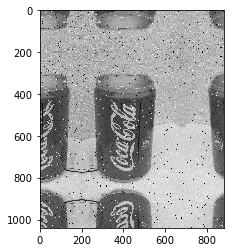

In [3]:
def imgmirror(mat, w):
    row,col = mat.shape
    right = np.flip(mat[:,col-w:col],1)
    left = np.flip(mat[:,0:w],1)
    mirr_mat = np.hstack((left, mat))
    mirr_mat = np.hstack((mirr_mat,right))
    up = np.flip(mirr_mat[0:w,:],0)
    down = np.flip(mirr_mat[row-w:row,:],0)
    mirr_mat = np.vstack((up, mirr_mat))
    mirr_mat = np.vstack((mirr_mat,down))
    return mirr_mat

#show mirrored image for demonstration 
mirr_img = imgmirror(img,200)
print(img.shape, mirr_img.shape)
plt.imshow(mirr_img, cmap="gray")

When using a kernel $K$ of size $(h\times h)$, the borders of the image should be mirrored with strips of size $\frac{h}{2}$ rounded down to the closest integer.

## 2.2 Gauss Filter
We will implement the function *gaussfilter*, which filters the matrix $I_1 \in \mathbb{R}^{n\times m}$ with kernel $K$ of size $(h\times h)$ (with standard deviation of $\sigma$ and zero of $\mu$ ). We will use our function *imgmirror* to handle the boundaries. The matrix $I_2 \in \mathbb{R}^{n\times m}$ is the output of the function.

In [4]:
def gaussfilter(mat, h, sigma):
    row, col = mat.shape
    a = h//2 #width of mirrored strip
    
    #Generate kernel array
    k = np.arange(-h // 2 + 1., h // 2 + 1.)
    x, y = np.meshgrid(k, k)
    c = 1/(2*math.pi*np.square(sigma))
    kernel = c*np.exp(-(np.square(x) + np.square(y)) / (2*np.square(sigma)))
    
    filter_img = np.full(mat.shape,0)
    mat_mirr = imgmirror(mat,a)
    start = time.time()
    for x in range(row):
        for y in range(col):
            filter_img[x][y] = np.sum(np.multiply(mat_mirr[x:x+h,y:y+h],kernel))
    end = time.time()
    print("Runtime: ",end-start)
    return filter_img

We see from the implemented function that the number of operations for each pixel in the filtered image depends on the shape of the input matrices, meaning that it increases when the size of either the kernel or image increases, therefore resulting in longer runtime.

## 2.3 Denoising

We will use these functions to denoise the corrupted picture noisycoke:jpg. We will use varying smoothing kernel size and with varying parameter $\sigma$ to observe the effects.

Runtime:  2.1200146675109863
Runtime:  2.09298038482666
Runtime:  2.6509759426116943


Text(0.5, 1.0, 'σ = 5, h = 25')

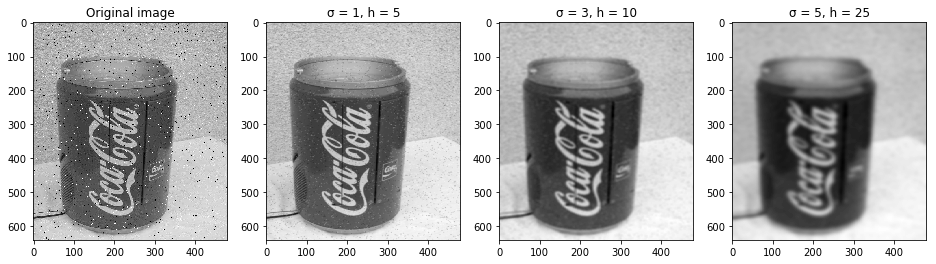

In [17]:
filter_img1 = gaussfilter(img,5,1)
filter_img2 = gaussfilter(img,10,3)
filter_img3 = gaussfilter(img,25,5)

f, axarr = plt.subplots(1,4, figsize=(16,4))
axarr[0].imshow(img,aspect="auto", cmap="gray")
axarr[0].set_title("Original image")
axarr[1].imshow(filter_img1,aspect="auto", cmap="gray")
axarr[1].set_title("σ = 1, h = 5")
axarr[2].imshow(filter_img2,aspect="auto", cmap="gray")
axarr[2].set_title("σ = 3, h = 10")
axarr[3].imshow(filter_img3,aspect="auto", cmap="gray")
axarr[3].set_title("σ = 5, h = 25")

From the images above, we observe that increasing kernel size casues the image to blur even more. Even though the noise is less visible with larger kernel, the egdes of the objects become less sharp. The $\sigma$ here controls the variation of Gaussian filter around its mean value. So as it becomes larger, the more variance allowed around mean.

## 2.4 Separable Gaussian
We will use the separability property of convolution operation and implement a new version of the function, *gaussfilter2*, which will be faster.

In [18]:
def gaussfilter2(mat, h, sigma):
    row, col = mat.shape
    a = h//2 #width of mirrored strip
    
    #Generate kernel array
    k = np.arange(-h // 2 + 1., h // 2 + 1.)
    #x, y = np.meshgrid(k, k)
    c = 1/(math.sqrt(2*math.pi)*sigma)
    kernel = c*np.exp(-(np.square(k)) / (2*np.square(sigma)))
    
    filter_img = np.full(mat.shape,0)
    mat_mirr = imgmirror(mat,a)
    start = time.time()
    for x in range(row):
        for y in range(col):
                    conv_row = np.matmul(kernel,mat_mirr[x:x+h,y:y+h])
                    filter_img[x][y] = np.matmul(kernel,conv_row)
    end = time.time()
    print("Runtime: ",end-start)
    return filter_img

Runtime:  1.365995168685913
Runtime:  1.3610270023345947
Runtime:  1.5999763011932373


Text(0.5, 1.0, 'σ = 5, h = 25')

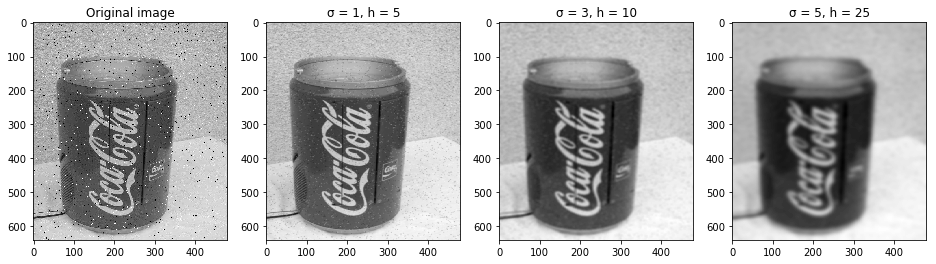

In [19]:
filter_img1_ = gaussfilter2(img,5,1)
filter_img2_ = gaussfilter2(img,10,3)
filter_img3_ = gaussfilter2(img,25,5)

f, axarr = plt.subplots(1,4, figsize=(16,4))
axarr[0].imshow(img,aspect="auto", cmap="gray")
axarr[0].set_title("Original image")
axarr[1].imshow(filter_img1_,aspect="auto", cmap="gray")
axarr[1].set_title("σ = 1, h = 5")
axarr[2].imshow(filter_img2_,aspect="auto", cmap="gray")
axarr[2].set_title("σ = 3, h = 10")
axarr[3].imshow(filter_img3_,aspect="auto", cmap="gray")
axarr[3].set_title("σ = 5, h = 25")

In [20]:
img_same = (filter_img1==filter_img1_).all() and (filter_img2==filter_img2_).all() and (filter_img3==filter_img3_).all()
print(img_same)

True


As we see from the runtime values, implementing the gaussian filter as two separate 1d filters is way faster than the 2d filter, even though both result in identical images. </br>
If we have a kernel $K$ of size $(h\times h)$ and an image $I \in \mathbb{R}^{n\times m}$, the number of operations for the two filters will be:</br>
- One 2D Convolution: $h^2mn$ (grows quadratically)
- Two 1D Convolutions: $2hmn$ (grows linearly)
